In [1]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv

load_dotenv()

memory = MemorySaver()

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools=tools)

class BasicState(TypedDict): 
    messages: Annotated[List, add_messages]

def model(state: BasicState): 
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tools_router(state: BasicState): 
    last_message = state["messages"][-1]
    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tools"
    else: 
        return END

tool_node = ToolNode(
    tools = tools
)

graph = StateGraph(BasicState)
graph.add_node("model", model)
graph.add_node("tools", tool_node)

graph.set_entry_point("model")
graph.add_conditional_edges("model", tools_router)

graph.add_edge("tools", "model")

app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

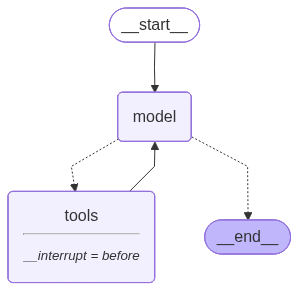

In [2]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [3]:
config = {"configurable": {
    "thread_id": 1
}}

events = app.stream({
    "messages": [HumanMessage(content="What is the current weather in Chennai?")]
}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the current weather in Chennai?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (jct0ebjz8)
 Call ID: jct0ebjz8
  Args:
    query: Chennai current weather


In [4]:
print(app.get_state(config).next)

('tools',)


In [5]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (jct0ebjz8)
 Call ID: jct0ebjz8
  Args:
    query: Chennai current weather
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://world-weather.info/forecast/india/chennai_1/november-2025/", "content": "Weather in Chennai in November 2025. Chennai Weather Forecast for November ... Monday, 17 November. Day. +79°. 15.7. 29.8. 84%. +79°. 06:08 am. 05:39 pm. Waning"}, {"url": "https://www.accuweather.com/en/in/chennai/206671/november-weather/206671", "content": "Get the monthly weather forecast for Chennai, Tamil Nadu, India, including daily high/low, historical averages, to help you plan ahead."}]
================================== Ai Message ==================================

The function call returned a JSON response. However, the question asked for the current weather, but the returned JS